# Notebook 2
In this notebook, we present the functions used to create Figure 4 in the article **TDA captures HGT in AMR gene families among clinically relevant bacteria**.
## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import gudhi as gd
from scipy.spatial.distance import hamming
import kaleido
import plotly.graph_objs as go
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
plt.rcParams['font.sans-serif'] = ['Liberation Sans']

## Define functions
These functions calculate a Hamming distance matrix from an array where the columns are genes and the rows are genomes.

In [2]:
# Let's assume that "population" is a numpy ndarray with your genomes as rows.
def calculate_hamming_matrix(population):
    # Number of genomes
    num_genomes = population.shape[0]
    # Create an empty matrix for Hamming distances
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=int)
   # Calculate the Hamming distance between each pair of genomes
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # j=i+1 to avoid calculating the same distance twice
            # The Hamming distance is multiplied by the number of genes to convert it into an absolute distance
            distance = hamming(population[i], population[j]) * len(population[i])
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # The matrix is symmetric
    
    return hamming_matrix
# Assuming that "population" is a NumPy ndarray with your genomes as rows
def calculate_normalized_hamming_matrix(population):
    num_genomes = population.shape[0]
    num_genes = population.shape[1]
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=float)
    
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # It's not necessary to calculate when i == j
            # The sum of boolean comparisons will give the total number of differences
            distance = np.sum(population[i] != population[j]) / num_genes
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # Taking advantage of symmetry
    
    return hamming_matrix



The 'create_complex' function generates a 3-dimensional Rips simplicial complex and computes persistent homology from a distance matrix.

In [3]:
def create_complex(distance_matrix):
    # Create the Rips simplicial complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix)
    # Create the simplex tree from the Rips complex with a maximum dimension of 3
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    # Compute the persistence of the simplicial complex
    persistence = simplex_tree.persistence()
    # Return the persistence diagram or barcode
    return persistence, simplex_tree
#### Function for visualization
def plot_dendrogram(data):
    """Plot a dendrogram from the data."""
    linked = linkage(data, 'single')
    dendrogram(linked, orientation='top', distance_sort='descending')
    plt.show()


The visualize_simplicial_complex function creates a graphical representation of a simplicial complex for a given filtration level, based on a simplex tree.

In [20]:


def visualize_simplicial_complex(simplex_tree, filtration_value, vertex_names=None, save_filename=None, plot_size=1, dpi=600):
    G = nx.Graph()
    triangles = []
    color_map = plt.get_cmap('coolwarm')

    # Create a dictionary to map simplices to colors based on their filtration values
    simplex_colors = {}
    max_filtration = max(filt for _, filt in simplex_tree.get_filtration() if filt <= filtration_value)

    for simplex, filt in simplex_tree.get_filtration():
        if filt <= filtration_value:
            # Normalize the filtration value and get the corresponding color
            normalized_value = filt / max_filtration
            color = color_map(normalized_value)
            rgba_color = 'rgba({}, {}, {}, {})'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255), color[3])
            simplex_colors[tuple(simplex)] = rgba_color

            # Add nodes and edges/triangles to the graph
            if len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])
            elif len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 3:
                triangles.append(simplex)

    # Position nodes using NetworkX's spring layout
    pos = nx.spring_layout(G)

    # Node trace
    x_values = [pos[key][0] for key in pos]
    y_values = [pos[key][1] for key in pos]
    node_labels = [vertex_names[node] if vertex_names else node for node in pos]
    #node_trace = go.Scatter(x=x_values, y=y_values, mode='markers+text', hoverinfo="text", marker=dict(size=10), text=node_labels, textposition='top center')
    node_trace = go.Scatter(x=x_values, y=y_values, mode='markers+text', hoverinfo="text",marker=dict(size=14), text=node_labels, textposition='top center', textfont=dict(size=14))

    
    # Edge traces
    edge_traces = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        color = simplex_colors.get(edge, 'rgba(0, 0, 0, 0.5)')  # Default color if edge not in simplex_colors
        edge_trace = go.Scatter(x=[x0, x1, None], y=[y0, y1, None], mode='lines', line=dict(width=3, color=color))
        edge_traces.append(edge_trace)

        # Triangle traces
    triangle_traces = []
    for triangle in triangles:
        x0, y0 = pos[triangle[0]]
        x1, y1 = pos[triangle[1]]
        x2, y2 = pos[triangle[2]]
    # Utilizando el nuevo color RGBA para los triángulos
        color = 'rgba(244, 157, 126, 0.545)'  # Color #F49D7E en formato RGBA
        triangle_trace = go.Scatter(x=[x0, x1, x2, x0, None], y=[y0, y1, y2, y0, None], fill='toself', mode='lines', line=dict(width=3), fillcolor=color)
        triangle_traces.append(triangle_trace)

    # Combine all traces and create the figure

    layout = go.Layout(showlegend=False, hovermode='closest', xaxis=dict(showgrid=False, zeroline=False,tickfont=dict(size=16, family='Arial, sans-serif') ), yaxis=dict(showgrid=False, zeroline=False,tickfont=dict(size=16, family='Arial, sans-serif')))

    fig = go.Figure(data=edge_traces + triangle_traces + [node_trace], layout=layout)

    # Set the figure size
    fig.update_layout(width=plot_size * dpi, height=plot_size * dpi)

    # Save the figure if a filename is provided
    if save_filename:
        pio.write_image(fig, save_filename, width=plot_size * dpi, height=plot_size * dpi, scale=1)

    # Show the figure
    fig.show()

    return G


## Import data
We imported the gene count table for the *Escherichia* and *Klebsiella* strains referenced in our work.


In [5]:
link="https://raw.githubusercontent.com/shadayguerrero/TDA_Horizontal_Genes_Transfer/main/data/BVBRC_protein_families_all_final.csv"
short=pd.read_csv(link,index_col=0)
short
# Re-index for the Strain
df_reindexed = short.set_index('Strain', inplace=False)
df_reindexed

,Taxonomy,RefSeq,UPF0758 protein YeeS (PGF_00064380),Uncharacterized protein YeeT (PGF_00065498),YeeU protein (antitoxin to YeeV) (PGF_00067294),YeeV toxin protein (PGF_00067296),hypothetical protein (PGF_08225224),Mobile element protein (PGF_01000105),Z1226 protein (PGF_00067424),hypothetical protein (PGF_00111192),...,hypothetical protein (PGF_04250059),hypothetical protein (PGF_03025936),hypothetical protein (PGF_00095896),hypothetical protein (PGF_06336094),Conjugal transfer protein traA (PGF_02995735),hypothetical protein (PGF_05449663),hypothetical protein (PGF_00284742),hypothetical protein (PGF_05076506),hypothetical protein (PGF_03326581),hypothetical protein (PGF_05267434)
Strain,,,,,,,,,,,,,,,,,,,,,
EC00690,Escherichia coli,GCF_012952545.1,4,4,4,4,193,63,3,0,...,0,0,0,0,0,0,0,0,0,0
EC00668,Escherichia coli,GCF_012952605.1,3,3,3,2,164,49,1,0,...,0,0,0,0,0,0,0,0,0,0
EC00609,Escherichia coli,GCF_012952615.1,7,6,5,5,189,66,4,0,...,0,0,0,0,0,0,0,0,0,0
EC00701,Escherichia coli,GCF_012952535.1,3,3,4,3,181,58,2,0,...,0,0,0,0,0,0,0,0,0,0
EC00678,Escherichia coli,GCF_012952555.1,6,6,6,5,142,20,4,2,...,0,0,0,0,0,0,0,0,0,0
KLP00215,Klebsiella pneumoniae,GCF_012952415.1,0,0,0,0,221,21,0,0,...,0,0,0,0,0,0,0,0,0,0
KLP00221,Klebsiella pneumoniae,GCF_012952335.1,0,0,0,0,16,30,0,0,...,0,0,0,0,0,0,0,0,0,0
KLP00218,Klebsiella pneumoniae,GCF_012952365.1,0,0,0,0,251,11,0,0,...,0,0,0,0,0,0,0,0,0,0
KLP00213,Klebsiella pneumoniae,GCF_012952385.1,0,0,0,0,219,27,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Convert to 1 and 0
#df_reindexed.iloc[:,2:]=df_reindexed.iloc[:,2:].applymap(lambda x: 1 if x > 0 else 0)
#df_reindexed


Select the family of genes that first appear in the IncF plasmid.

In [7]:

names_to_search = [
    "PGF_04886779", "PGF_04370656", "PGF_07342234", "PGF_03299821", "PGF_05419346",
    "PGF_03084064", "PGF_04563108", "PGF_00414310", "PGF_00022105", "PGF_05419346",
    "PGF_06607596", "PGF_00047661", "PGF_00216543", "PGF_08225224", "PGF_08225224",
    "PGF_00110526", "PGF_00355535", "PGF_01650562", "PGF_04243824", "PGF_02333019",
    "PGF_08225224", "PGF_03145724", "PGF_06495825", "PGF_00452501", "PGF_05493974",
    "PGF_00020282", "PGF_06958254", "PGF_09224510", "PGF_07563198", "PGF_01000105",
    "PGF_01031760", "PGF_01569843", "PGF_01077017", "PGF_01000105", "PGF_02752571",
    "PGF_00410347", "PGF_01958521", "PGF_08225224", "PGF_07207755", "PGF_00010376",
    "PGF_03543440", "PGF_05156704", "PGF_01000105", "PGF_01000105", "PGF_02932429",
    "PGF_06674747", "PGF_07498135", "PGF_10469466", "PGF_08225224", "PGF_01958554",
    "PGF_05971953", "PGF_00904239", "PGF_00424315", "PGF_08238808", "PGF_08225224",
    "PGF_08238808", "PGF_08225224", "PGF_00013862", "PGF_00013864", "PGF_10387734",
    "PGF_09290469", "PGF_08225224", "PGF_00013946", "PGF_01949998", "PGF_00013916",
    "PGF_08972330", "PGF_08225224", "PGF_00013925", "PGF_00013923", "PGF_03830470",
    "PGF_00326234", "PGF_00163448", "PGF_00013943", "PGF_02913871", "PGF_00013942",
    "PGF_00615364", "PGF_00335754", "PGF_07717077", "PGF_00013945", "PGF_00013871",
    "PGF_03332290", "PGF_08225224", "PGF_06611914", "PGF_00089171", "PGF_06560088",
    "PGF_00106691", "PGF_04419840", "PGF_00467825", "PGF_00013893", "PGF_00013875",
    "PGF_01246464", "PGF_00013866", "PGF_08225224", "PGF_00859415", "PGF_00013863",
    "PGF_00411196", "PGF_00326542", "PGF_00064344", "PGF_07396822", "PGF_07978541",
    "PGF_01595863", "PGF_06275535", "PGF_06275535", "PGF_01950491", "PGF_01958592",
    "PGF_01009331", "PGF_00038929", "PGF_00038932", "PGF_05682743", "PGF_00064362",
    "PGF_02142873", "PGF_04180579", "PGF_00072490", "PGF_07517035", "PGF_00324174",
    "PGF_00106708", "PGF_10494469", "PGF_08970263", "PGF_08225224", "PGF_00060224", 
    "PGF_00415171", "PGF_07518314", "PGF_00424726"]
selected_columns = [col for col in df_reindexed.columns if any(word in col for word in names_to_search)]
column_index = [df_reindexed.columns.get_loc(col) for col in selected_columns]

# Create a new DataFrame with only the selected columns
df_filtered = df_reindexed[selected_columns]

len(names_to_search)

123

We extract the names of the Strains from the table.

In [8]:
strain_names=list(df_reindexed.index)

We select a window of 500 genes that includes the genes from the IncF plasmid belonging to the strain EC00678.

In [9]:
#PatientA_B=all.iloc[:,4438:4520].values
PatientA_B=df_reindexed.iloc[:,4020:4520].values
PatientA_B

array([[0, 1, 1, ..., 0, 2, 0],
       [1, 1, 1, ..., 0, 3, 0],
       [0, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 2, 2],
       [0, 1, 1, ..., 0, 0, 0]])

In [10]:
PatientA_B.shape

(12, 500)

## Homlogy persistence
In this section, we apply persistent homology and plot the persistence diagram and barcode, as well as the geometric representation of the simplicial complex for various levels of filtration.







In [11]:
hamming_matrix_3 = calculate_hamming_matrix(PatientA_B)
persistence3, simplex_tree3 = create_complex(hamming_matrix_3)
persistence3

[(1, (118.0, 145.0)),
 (1, (88.0, 112.0)),
 (0, (0.0, inf)),
 (0, (0.0, 108.0)),
 (0, (0.0, 85.0)),
 (0, (0.0, 72.0)),
 (0, (0.0, 61.0)),
 (0, (0.0, 53.0)),
 (0, (0.0, 43.0)),
 (0, (0.0, 31.0)),
 (0, (0.0, 30.0)),
 (0, (0.0, 18.0)),
 (0, (0.0, 18.0)),
 (0, (0.0, 18.0))]

usetex mode requires dvipng.


<Figure size 100x100 with 0 Axes>

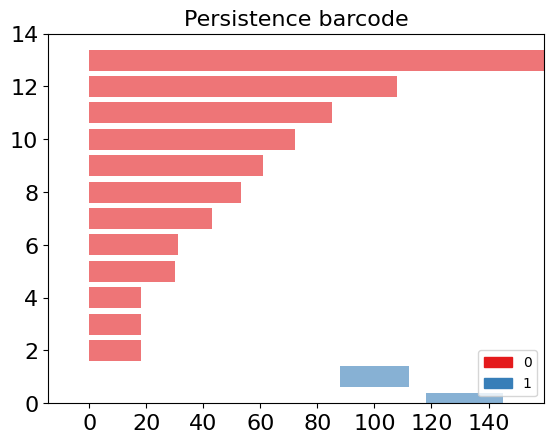

In [12]:
# Adjusting the size of the plot
plt.figure(figsize=(1, 1))  # You can adjust these numbers as per your needs
# Adjusting the layout
plt.tight_layout()
gd.plot_persistence_barcode(persistence3, legend=True)
plt.xticks(fontsize=16)  # Adjust the size as needed
plt.yticks(fontsize=16)
plt.savefig("plots/barcode_patientA_B.svg", dpi=600)
plt.savefig("plots/barcode_patientA_B.png", dpi=600)


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

<Figure size 1000x1000 with 0 Axes>

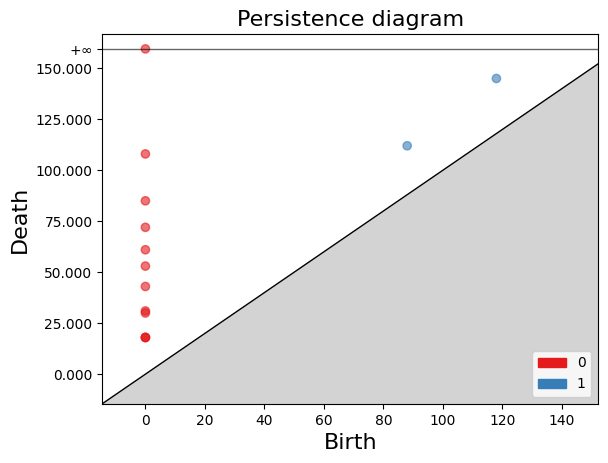

In [13]:
# Adjust the size of the plot
plt.figure(figsize=(10, 10))  # You can adjust these numbers according to your needs
# Adjust the layout
plt.tight_layout()
gd.plot_persistence_diagram(persistence3, legend=True)
#plt.savefig("plots/diagram_patientA_B.svg", dpi=600)
#plt.savefig("plots/diagram_patientA_B.png", dpi=600)


In [19]:
visualize_simplicial_complex(simplex_tree3,108,strain_names,save_filename="plots/simplicial_108.svg")

In [15]:
visualize_simplicial_complex(simplex_tree3,119,strain_names,save_filename="plots/simplicial_119.svg")

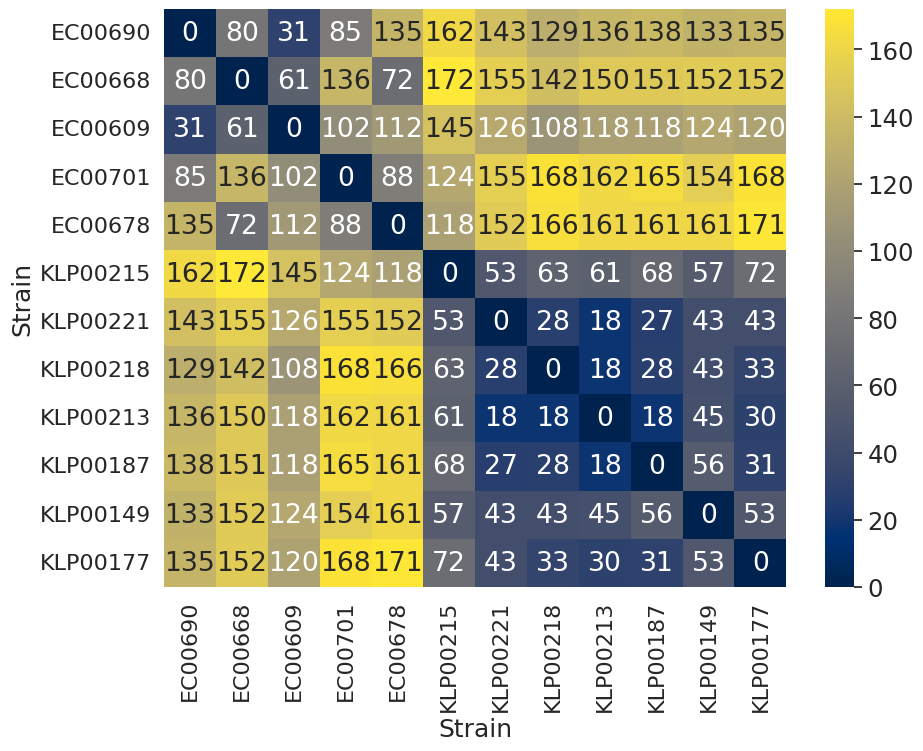

In [17]:
# Adjust the size of the plot
plt.figure(figsize=(10, 8))  # You can adjust these numbers according to your needs

# Create the heatmap
sns.heatmap(hamming_matrix_3, annot=True, cmap='cividis', xticklabels=strain_names, yticklabels=strain_names, fmt='.0f')

# Add titles and labels if necessary
#plt.title('Heatmap for Hamming Matrix')
plt.xlabel('Strain', fontsize=18)
plt.ylabel('Strain', fontsize=18)

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig("plots/heatmap_hamming.svg", dpi=600)
#plt.savefig("plots/heatmap_hamming.png", dpi=600)
# Increase the size of the axis labels
plt.xticks(fontsize=16)  # Adjust the size as needed
plt.yticks(fontsize=16)
sns.set(font_scale=1.6)
# Display the plot
plt.show()
